<h2 style="color: orange; text-align: center;">Data Preparation</h2>

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.io import savemat
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
import contextily as ctx
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
import os
import warnings
warnings.filterwarnings('ignore')


<h2 style="color: orange; text-align: center;">Load Bike Sharing Data</h2>

In [2]:
# Directory of historical bike-sharing files
base_path = r"../data_inputs_for_matlab/data_source/bikesharing_monthly"

# List of files with pathlib
bike_files = [f"{base_path}/2023{i:02d}.csv" for i in range(1, 13)]

# Load All Files into a Single DataFrame
bike_data = pd.concat([pd.read_csv(file) for file in bike_files], ignore_index=True)

# Convert Time Columns to Datetime
bike_data['started_at'] = pd.to_datetime(bike_data['started_at'])
bike_data['ended_at'] = pd.to_datetime(bike_data['ended_at'])

# Filter Data for 2023
bike_data = bike_data[bike_data['started_at'].dt.year == 2023]

<h2 style="color: orange; text-align: center;">Addition of the dateday column</h2>

In [3]:
bike_data['dateday'] = bike_data['started_at'].dt.date

In [4]:
bike_data.head(5)

ride_id rideable_type          started_at            ended_at  \
0  65F0ACD101BF0D49  classic_bike 2023-01-04 19:34:07 2023-01-04 19:39:29   
1  D75158CE73DC43F0  classic_bike 2023-01-27 15:26:38 2023-01-27 19:21:36   
2  33E85889625FF7CA  classic_bike 2023-01-05 20:44:38 2023-01-05 20:51:18   
3  E1F055A1651F47A1  classic_bike 2023-01-03 17:45:14 2023-01-03 17:57:23   
4  88CC90CEEC298BAF  classic_bike 2023-01-03 05:18:46 2023-01-03 05:25:50   

                                  start_station_name  start_station_id  \
0  East Falls Church Metro / Sycamore St & 19th St N           31904.0   
1                         Carroll & Westmoreland Ave           32025.0   
2                                     15th & L St NW           31276.0   
3                             Hartland Rd & Harte Pl           32255.0   
4         Merrifield Cinema & Merrifield Town Center           32235.0   

                             end_station_name  end_station_id  start_lat  \
0             W Columbia St & N Washington St         32609.0  38.885321   
1                   Fenton St & Ellsworth Dr          32036.0  38.975000   
2                               Thomas Circle         31241.0  38.903649   
3  Merrifield Cinema & Merrifield Town Center         32235.0  38.878601   
4                      Hartland Rd & Harte Pl         32255.0  38.870093   

   start_lng    end_lat    end_lng member_casual     dateday  
0 -77.156427  38.885621 -77.166917        member  2023-01-04  
1 -77.011210  38.997033 -77.025608        member  2023-01-27  
2 -77.034918  38.905900 -77.032500        member  2023-01-05  
3 -77.222808  38.870093 -77.229970        member  2023-01-03  
4 -77.229970  38.878601 -77.222808        member  2023-01-03

<h2 style="color: orange; text-align: center;">Remove irregular records, such as those with an unknown end station</h2>

In [5]:
invalid_records = bike_data[
    bike_data['end_station_id'].isna()
]

invalid_records

ride_id  rideable_type          started_at  \
31       25FF612DB868730D  electric_bike 2023-01-24 13:15:25   
1678     974E66A3E16F363F  electric_bike 2023-01-08 18:37:07   
1679     FC161040EEC19382   classic_bike 2023-01-06 17:50:05   
1680     51E5D078B47925F3  electric_bike 2023-01-25 18:43:08   
1683     65B76E48116EA5F6  electric_bike 2023-01-28 17:30:46   
...                   ...            ...                 ...   
4436462  B9A535CBE1993F59  electric_bike 2023-12-29 17:08:42   
4436463  BC2BA8CAB8A08654  electric_bike 2023-12-16 14:08:38   
4436464  1AA9B49C957E502D  electric_bike 2023-12-11 12:32:07   
4436465  7D452C7607246724  electric_bike 2023-12-28 17:08:40   
4436466  6076C76AA5FDCCBD  electric_bike 2023-12-25 18:17:26   

                   ended_at               start_station_name  \
31      2023-01-24 13:17:26       34th St & Wisconsin Ave NW   
1678    2023-01-08 18:49:28                   Tanger Outlets   
1679    2023-01-07 18:49:58                Whiting & Lane Dr   
1680    2023-01-25 18:43:10                    4th & W St NE   
1683    2023-01-28 17:33:19                    7th & K St NW   
...                     ...                              ...   
4436462 2023-12-29 17:44:00  Marion Barry Ave & Naylor Rd SE   
4436463 2023-12-16 14:45:52  Marion Barry Ave & Naylor Rd SE   
4436464 2023-12-11 12:43:23            21st St & N Pierce St   
4436465 2023-12-28 17:36:43  Marion Barry Ave & Naylor Rd SE   
4436466 2023-12-25 19:24:17                   Van Dorn Metro   

         start_station_id end_station_name  end_station_id  start_lat  \
31                31226.0              NaN             NaN  38.916483   
1678              32415.0              NaN             NaN  38.796900   
1679              31942.0              NaN             NaN  38.809709   
1680              31500.0              NaN             NaN  38.919072   
1683              31653.0              NaN             NaN  38.902702   
...                   ...              ...             ...        ...   
4436462           31700.0              NaN             NaN  38.861667   
4436463           31700.0              NaN             NaN  38.861652   
4436464           31093.0              NaN             NaN  38.898928   
4436465           31700.0              NaN             NaN  38.861575   
4436466           31932.0              NaN             NaN  38.800131   

         start_lng  end_lat  end_lng member_casual     dateday  
31      -77.068194    38.91   -77.07        casual  2023-01-24  
1678    -77.002705    38.79   -77.02        casual  2023-01-08  
1679    -77.135788      NaN      NaN        casual  2023-01-06  
1680    -77.000641    38.92   -77.00        member  2023-01-25  
1683    -77.021738    38.91   -77.02        casual  2023-01-28  
...            ...      ...      ...           ...         ...  
4436462 -76.969167    38.91   -76.94        member  2023-12-29  
4436463 -76.969149    38.91   -76.94        member  2023-12-16  
4436464 -77.078391    38.90   -77.05        member  2023-12-11  
4436465 -76.969155    38.89   -76.95        member  2023-12-28  
4436466 -77.129940    38.80   -77.06        member  2023-12-25  

[432484 rows x 14 columns]

In [6]:
bike_data = bike_data.dropna(subset=['end_station_id'])
bike_data = bike_data.dropna(subset=['start_station_id'])
bike_data = bike_data[bike_data['rideable_type'] != 'docked_bike']


<h2 style="color: orange; text-align: center;">Calculation of travel duration</h2>

In [7]:
bike_data['duration'] = (bike_data['ended_at'] - bike_data['started_at']).dt.total_seconds() / 60
bike_data['duration'] = bike_data['duration'].abs()

In [8]:
bike_data = bike_data[bike_data['end_station_id'] != bike_data['start_station_id']]
bike_data = bike_data[bike_data['duration'] >= 1]


In [9]:
bike_data.head(5)

ride_id rideable_type          started_at            ended_at  \
0  65F0ACD101BF0D49  classic_bike 2023-01-04 19:34:07 2023-01-04 19:39:29   
1  D75158CE73DC43F0  classic_bike 2023-01-27 15:26:38 2023-01-27 19:21:36   
2  33E85889625FF7CA  classic_bike 2023-01-05 20:44:38 2023-01-05 20:51:18   
3  E1F055A1651F47A1  classic_bike 2023-01-03 17:45:14 2023-01-03 17:57:23   
4  88CC90CEEC298BAF  classic_bike 2023-01-03 05:18:46 2023-01-03 05:25:50   

                                  start_station_name  start_station_id  \
0  East Falls Church Metro / Sycamore St & 19th St N           31904.0   
1                         Carroll & Westmoreland Ave           32025.0   
2                                     15th & L St NW           31276.0   
3                             Hartland Rd & Harte Pl           32255.0   
4         Merrifield Cinema & Merrifield Town Center           32235.0   

                             end_station_name  end_station_id  start_lat  \
0             W Columbia St & N Washington St         32609.0  38.885321   
1                   Fenton St & Ellsworth Dr          32036.0  38.975000   
2                               Thomas Circle         31241.0  38.903649   
3  Merrifield Cinema & Merrifield Town Center         32235.0  38.878601   
4                      Hartland Rd & Harte Pl         32255.0  38.870093   

   start_lng    end_lat    end_lng member_casual     dateday    duration  
0 -77.156427  38.885621 -77.166917        member  2023-01-04    5.366667  
1 -77.011210  38.997033 -77.025608        member  2023-01-27  234.966667  
2 -77.034918  38.905900 -77.032500        member  2023-01-05    6.666667  
3 -77.222808  38.870093 -77.229970        member  2023-01-03   12.150000  
4 -77.229970  38.878601 -77.222808        member  2023-01-03    7.066667

<h2 style="color: orange; text-align: center;">Map of Washington, DC: Bike Stations Highlighted</h2>

In [18]:
start_stations = bike_data[['start_station_id', 'start_station_name', 'start_lat', 'start_lng']]


unique_start_stations = start_stations.drop_duplicates(subset=['start_station_id']).reset_index(drop=True)


print(f"Number of distinct stations: {unique_start_stations.shape[0]}")


unique_start_stations.head(5)


Number of distinct stations: 766


start_station_id                                 start_station_name  \
0           31904.0  East Falls Church Metro / Sycamore St & 19th St N   
1           32025.0                         Carroll & Westmoreland Ave   
2           31276.0                                     15th & L St NW   
3           32255.0                             Hartland Rd & Harte Pl   
4           32235.0         Merrifield Cinema & Merrifield Town Center   

   start_lat  start_lng  
0  38.885321 -77.156427  
1  38.975000 -77.011210  
2  38.903649 -77.034918  
3  38.878601 -77.222808  
4  38.870093 -77.229970

In [17]:

m = folium.Map(location=[38.9072, -77.0369], zoom_start=12)

for index, row in unique_start_stations.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=2,  
        popup=row['start_station_name'],
        color='green',  
        fill=True,  
        fill_color='green',  
        fill_opacity=0.6  
    ).add_to(m)


m.save("output/washington_bike_stations.html")
m  


<h2 style="color: orange; text-align: center;">Creation of the daily dataset</h2>

In [140]:
holidays = [
    datetime(2023, 1, 2).date(),   # New Year's Day
    datetime(2023, 1, 16).date(),  # Dr. Martin Luther King, Jr.'s Birthday
    datetime(2023, 2, 20).date(),  # Washington's Birthday
    datetime(2023, 4, 17).date(),  # D.C. Emancipation Day
    datetime(2023, 5, 29).date(),  # Memorial Day
    datetime(2023, 6, 19).date(),  # Juneteenth National Independence Day
    datetime(2023, 7, 4).date(),   # Independence Day
    datetime(2023, 9, 4).date(),   # Labor Day
    datetime(2023, 10, 9).date(),  # Indigenous Peoples' Day
    datetime(2023, 11, 10).date(), # Veterans Day
    datetime(2023, 11, 23).date(), # Thanksgiving Day
    datetime(2023, 12, 25).date()  # Christmas Day
]


def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Fall
    else:
        return 4  # Winter


daily_data = bike_data.groupby('dateday').agg(
    cnt=('ride_id', 'count'),
    duration=('duration', 'sum')
).reset_index()


daily_data['season'] = daily_data['dateday'].apply(lambda x: get_season(x))
daily_data['month'] = daily_data['dateday'].apply(lambda x: x.month)
daily_data['weekday'] = daily_data['dateday'].apply(lambda x: x.weekday())  # 0 = Monday, 6 = Sunday
daily_data['workingday'] = daily_data['weekday'].apply(lambda x: 0 if x in [5, 6] else 1)
daily_data['holidays'] = daily_data['dateday'].apply(lambda x: 1 if x in holidays else 0)


daily_data = daily_data[['dateday', 'season', 'month', 'weekday', 'workingday', 'holidays', 'cnt', 'duration']]


In [141]:
daily_data.rename(columns={'duration': 'duration_min'}, inplace=True)

In [142]:
daily_data['duration_hr'] = daily_data['duration_min'] / 60

In [143]:
daily_data.head(14)

dateday  season  month  weekday  workingday  holidays   cnt  \
0   2023-01-01       4      1        6           0         0  5114   
1   2023-01-02       4      1        0           1         1  5766   
2   2023-01-03       4      1        1           1         0  6409   
3   2023-01-04       4      1        2           1         0  6694   
4   2023-01-05       4      1        3           1         0  7118   
5   2023-01-06       4      1        4           1         0  5876   
6   2023-01-07       4      1        5           0         0  6085   
7   2023-01-08       4      1        6           0         0  4436   
8   2023-01-09       4      1        0           1         0  5773   
9   2023-01-10       4      1        1           1         0  6473   
10  2023-01-11       4      1        2           1         0  6461   
11  2023-01-12       4      1        3           1         0  5998   
12  2023-01-13       4      1        4           1         0  5715   
13  2023-01-14       4      1        5           0         0  4330   

     duration_min  duration_hr  
0   115511.966667  1925.199444  
1   114070.400000  1901.173333  
2    99069.250000  1651.154167  
3    96291.300000  1604.855000  
4   106219.433333  1770.323889  
5    80226.866667  1337.114444  
6    96123.016667  1602.050278  
7    67349.700000  1122.495000  
8    78946.600000  1315.776667  
9    85015.316667  1416.921944  
10   94678.533333  1577.975556  
11   82471.850000  1374.530833  
12   77952.433333  1299.207222  
13   64115.416667  1068.590278

<h2 style="color: orange; text-align: center;">Creation of the Hourly Dataset</h2>

In [144]:
bike_data['hour'] = bike_data['started_at'].dt.hour

In [145]:
hourly_data = bike_data.groupby(['dateday', 'hour']).agg(
    cnt=('ride_id', 'count'),
    duration=('duration', 'sum')
).reset_index()


hourly_data['season'] = hourly_data['dateday'].apply(lambda x: get_season(x))
hourly_data['month'] = hourly_data['dateday'].apply(lambda x: x.month)
hourly_data['weekday'] = hourly_data['dateday'].apply(lambda x: x.weekday())  # 0 = Monday, 6 = Sunday
hourly_data['workingday'] = hourly_data['weekday'].apply(lambda x: 0 if x in [5, 6] else 1)
hourly_data['holidays'] = hourly_data['dateday'].apply(lambda x: 1 if x in holidays else 0)


hourly_data = hourly_data[['dateday', 'hour', 'season', 'month', 'weekday', 'workingday', 'holidays', 'cnt', 'duration']]

In [146]:
hourly_data.head(5)

dateday  hour  season  month  weekday  workingday  holidays  cnt  \
0  2023-01-01     0       4      1        6           0         0  101   
1  2023-01-01     1       4      1        6           0         0  161   
2  2023-01-01     2       4      1        6           0         0  149   
3  2023-01-01     3       4      1        6           0         0   65   
4  2023-01-01     4       4      1        6           0         0   19   

      duration  
0  1410.616667  
1  3532.450000  
2  2874.166667  
3  1036.850000  
4   195.850000

In [147]:
hourly_data.rename(columns={'duration': 'duration_min'}, inplace=True)

In [148]:
hourly_data['duration_hr'] = hourly_data['duration_min'] / 60

In [149]:
hourly_data.head(5)

dateday  hour  season  month  weekday  workingday  holidays  cnt  \
0  2023-01-01     0       4      1        6           0         0  101   
1  2023-01-01     1       4      1        6           0         0  161   
2  2023-01-01     2       4      1        6           0         0  149   
3  2023-01-01     3       4      1        6           0         0   65   
4  2023-01-01     4       4      1        6           0         0   19   

   duration_min  duration_hr  
0   1410.616667    23.510278  
1   3532.450000    58.874167  
2   2874.166667    47.902778  
3   1036.850000    17.280833  
4    195.850000     3.264167

<h2 style="color: orange; text-align: center;">Save</h2>

In [150]:
daily_data.to_csv('output/daily_bike_data.csv', index=False)
hourly_data.to_csv('output/hourly_bike_data.csv', index=False)


<h2 style="color: orange; text-align: center;">Load Weather Data</h2>

In [151]:
base_path_weather = Path("../data_inputs_for_matlab/data_source/weather_data")

# Load Meteorological Data
file_name = "Washington, DC, United St... 2023-01-01 to 2023-12-31.csv"
weather_data = pd.read_csv(base_path_weather / file_name)

# Convert the Time Column to Datetime
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# Filter Data for 2023
weather_data = weather_data[weather_data['datetime'].dt.year == 2023]

# Select Relevant Columns
weather_data = weather_data[['datetime', 'temp', 'feelslike', 'humidity', 'precip', 'windspeed', 'cloudcover', 'visibility', 'uvindex']]

In [152]:
weather_data.rename(columns={'datetime': 'dateday'}, inplace=True)

In [153]:
weather_data['dateday'] = pd.to_datetime(weather_data['dateday']).dt.date

In [154]:
weather_data.head(5)

dateday  temp  feelslike  humidity  precip  windspeed  cloudcover  \
0  2023-01-01  11.0       10.7      82.2   0.101       14.2        47.7   
1  2023-01-02  10.5       10.1      79.3   0.000       14.7        87.8   
2  2023-01-03  15.2       15.2      78.5   0.000       28.5        90.8   
3  2023-01-04  15.3       15.3      85.4   0.000       22.8        85.2   
4  2023-01-05  13.5       13.3      70.4   0.000       20.2        75.8   

   visibility  uvindex  
0        14.6        4  
1        15.9        4  
2        15.6        2  
3        15.9        2  
4        15.9        4

<h2 style="color: orange; text-align: center;">Union of the Datasets</h2>

In [155]:
daily_data_enriched = pd.merge(daily_data, weather_data, on='dateday', how='left')

In [156]:
daily_data_enriched.head(5)

dateday  season  month  weekday  workingday  holidays   cnt  \
0  2023-01-01       4      1        6           0         0  5114   
1  2023-01-02       4      1        0           1         1  5766   
2  2023-01-03       4      1        1           1         0  6409   
3  2023-01-04       4      1        2           1         0  6694   
4  2023-01-05       4      1        3           1         0  7118   

    duration_min  duration_hr  temp  feelslike  humidity  precip  windspeed  \
0  115511.966667  1925.199444  11.0       10.7      82.2   0.101       14.2   
1  114070.400000  1901.173333  10.5       10.1      79.3   0.000       14.7   
2   99069.250000  1651.154167  15.2       15.2      78.5   0.000       28.5   
3   96291.300000  1604.855000  15.3       15.3      85.4   0.000       22.8   
4  106219.433333  1770.323889  13.5       13.3      70.4   0.000       20.2   

   cloudcover  visibility  uvindex  
0        47.7        14.6        4  
1        87.8        15.9        4  
2        90.8        15.6        2  
3        85.2        15.9        2  
4        75.8        15.9        4

<h2 style="color: orange; text-align: center;">Boxplot for Distribution of Bike Rentals per Hour</h2>

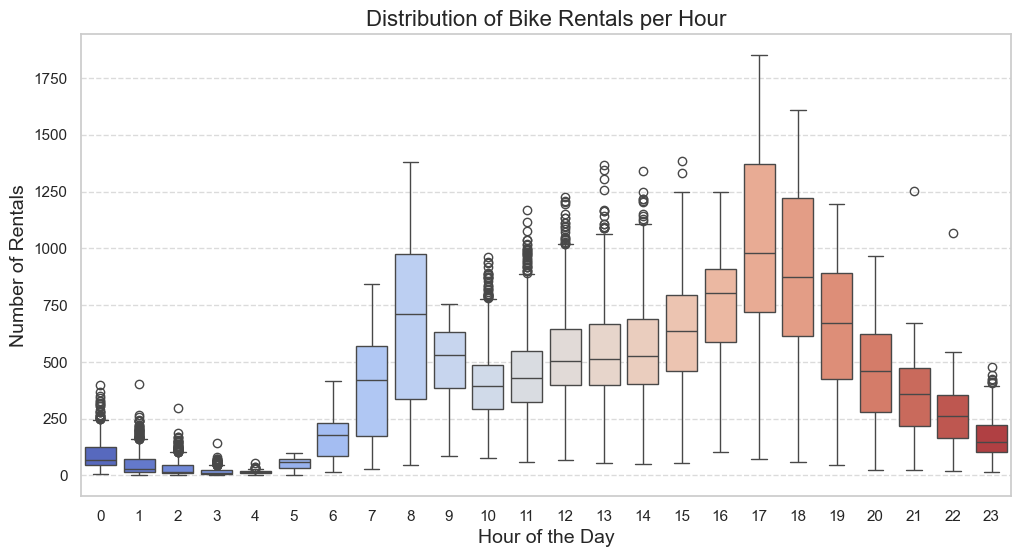

In [157]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='cnt', data=hourly_data, palette='coolwarm')
plt.title('Distribution of Bike Rentals per Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<h2 style="color: orange; text-align: center;">Boxplot for Distribution of Bike Rentals vs Days of the Week</h2>

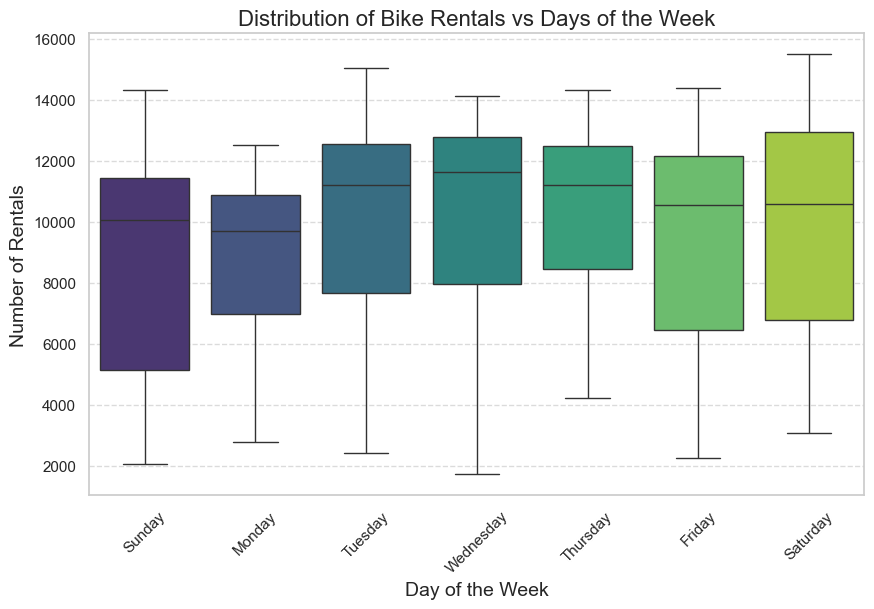

In [186]:
weekday_mapping = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}


daily_data_enriched['weekday'] = daily_data_enriched['weekday'].map(weekday_mapping)


plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y='cnt', data=daily_data_enriched, palette='viridis')
plt.title('Distribution of Bike Rentals vs Days of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  
plt.show()


<h2 style="color: orange; text-align: center;">Hourly Bike Rentals: Working Day vs Non-Working Day</h2>

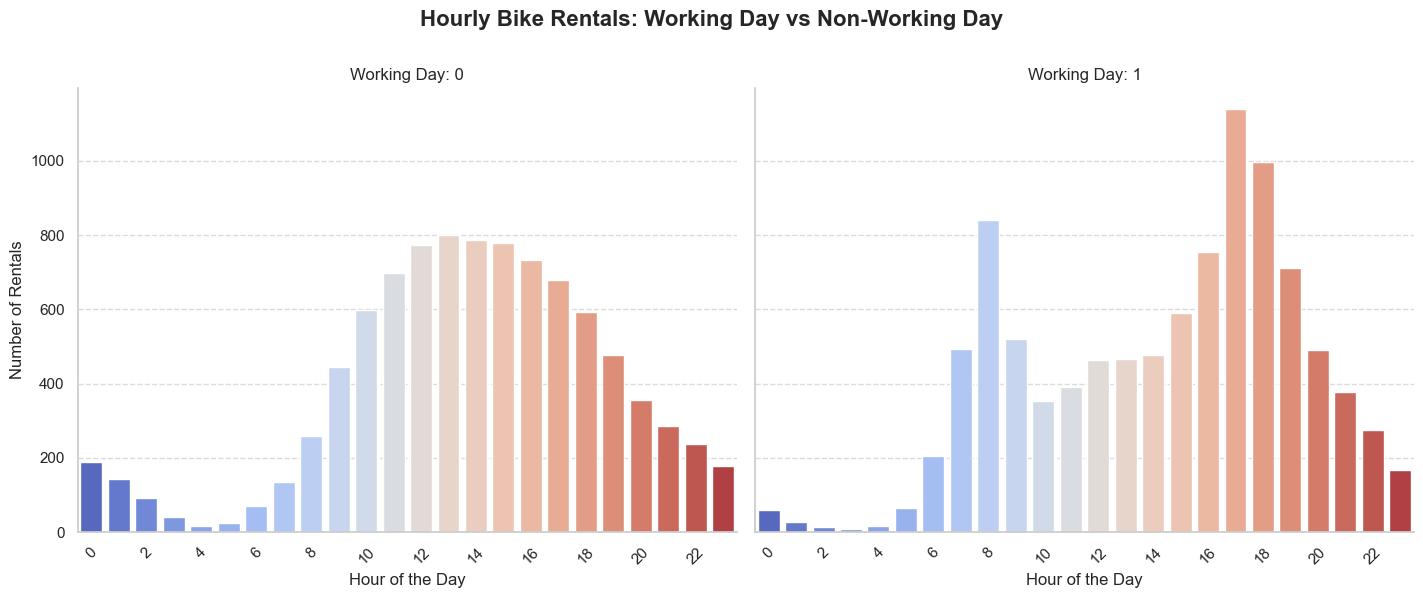

In [159]:

sns.set_theme(style="whitegrid")


g = sns.FacetGrid(hourly_data, col="workingday", height=6, aspect=1.2, palette="muted")


g.map(sns.barplot, "hour", "cnt", ci=None, palette="coolwarm")


g.set_axis_labels("Hour of the Day", "Number of Rentals")
g.set_titles("Working Day: {col_name}")


plt.subplots_adjust(top=0.85)
g.fig.suptitle("Hourly Bike Rentals: Working Day vs Non-Working Day", fontsize=16, fontweight="bold")


g.set(xticks=range(0, 24, 2))  # every 2 hours
g.set_xticklabels(rotation=45)  


for ax in g.axes.flat:
    ax.grid(axis="y", linestyle="--", alpha=0.7)


plt.show()

<h2 style="color: orange; text-align: center;">Boxplot for Distribution of Bike Rentals vs Months</h2>

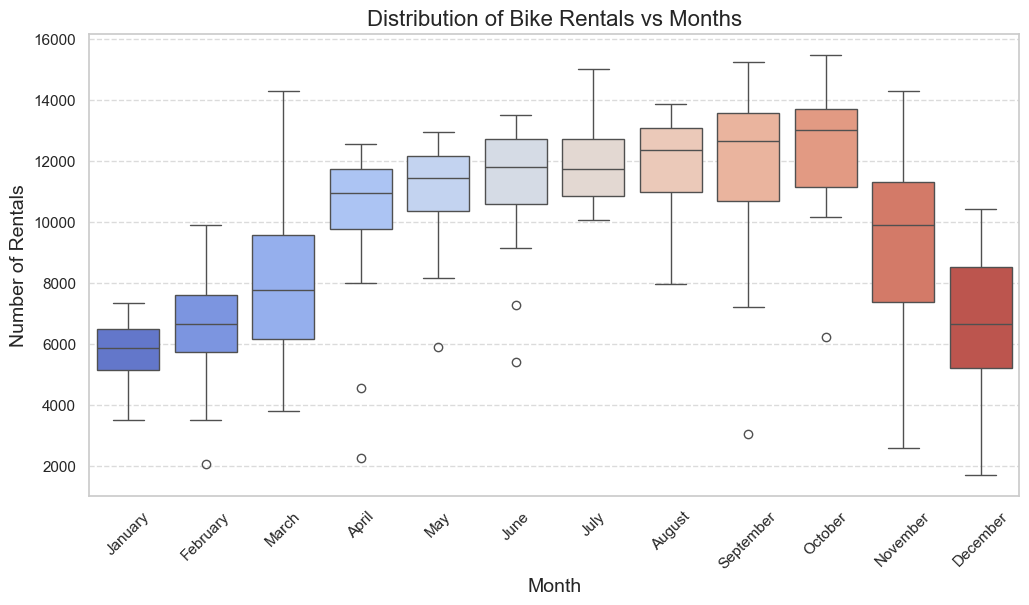

In [185]:
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}


daily_data_enriched['month'] = daily_data_enriched['month'].map(month_mapping)


plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='cnt', data=daily_data_enriched, palette='coolwarm')
plt.title('Distribution of Bike Rentals vs Months', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  
plt.show()


<h2 style="color: orange; text-align: center;">Boxplot for Distribution of Bike Rentals vs Seasons</h2>

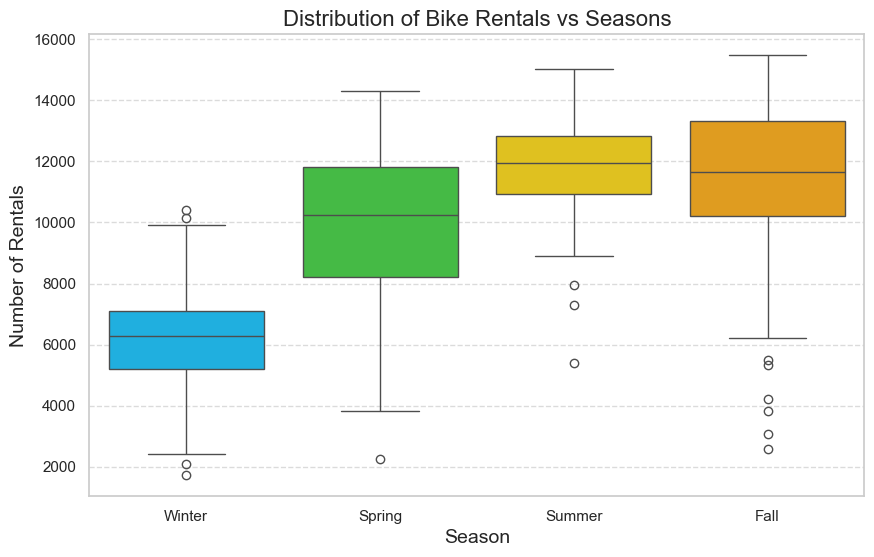

In [161]:
season_mapping = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
daily_data_enriched['season'] = daily_data_enriched['season'].map(season_mapping)


custom_palette = {
    'Spring': 'limegreen',  
    'Summer': 'gold',       
    'Fall': 'orange',       
    'Winter': 'deepskyblue' 
}


plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='cnt', data=daily_data_enriched, palette=custom_palette)
plt.title('Distribution of Bike Rentals vs Seasons', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<h2 style="color: orange; text-align: center;">Boxplot for Relationship Between Temperature Conditions vs Bike Rentals</h2>

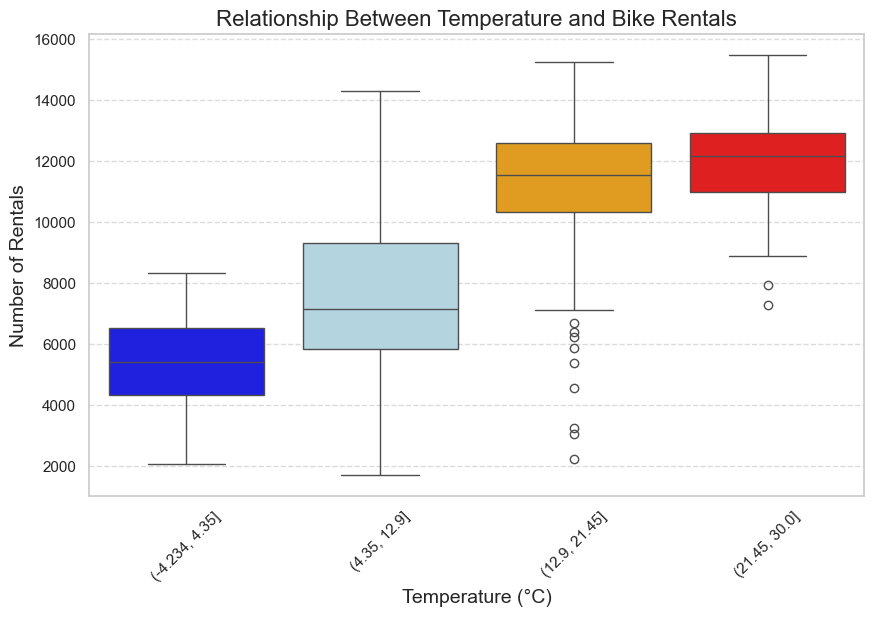

In [163]:
temperature_bins = pd.cut(daily_data_enriched['temp'], bins=4)


daily_data_enriched['temp_bins'] = pd.Categorical(
    temperature_bins,
    categories=temperature_bins.cat.categories,
    ordered=True
)


custom_palette_temp = ['blue', 'lightblue', 'orange', 'red']  
bin_labels = temperature_bins.cat.categories
bin_palette = {str(bin_label): color for bin_label, color in zip(bin_labels, custom_palette_temp)}


plt.figure(figsize=(10, 6))
sns.boxplot(x='temp_bins', y='cnt', data=daily_data_enriched, palette=bin_palette)
plt.title('Relationship Between Temperature and Bike Rentals', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()


<h2 style="color: orange; text-align: center;">Boxplot for Relationship Between Visibility Conditions vs Bike Rentals</h2>

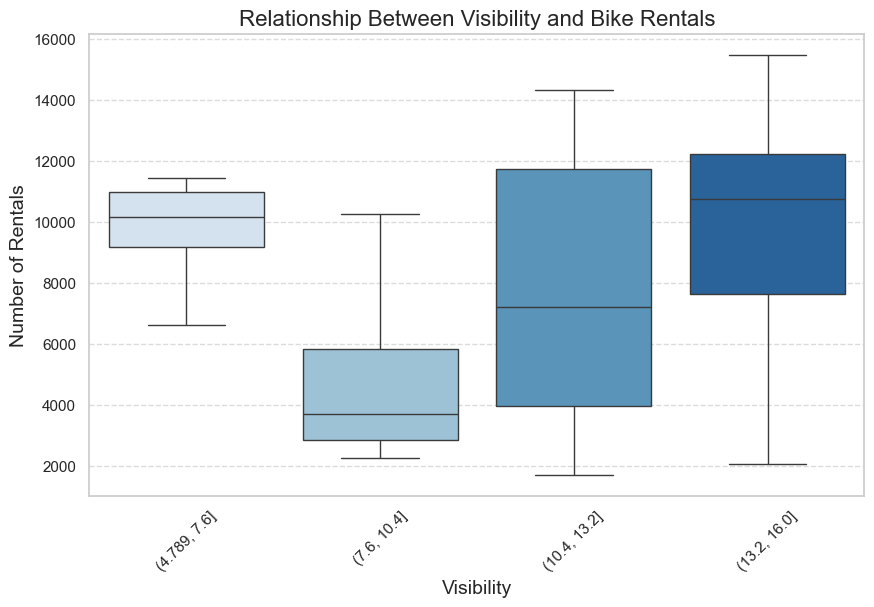

In [222]:
plt.figure(figsize=(10, 6))


sns.boxplot(x=pd.cut(daily_data_enriched['visibility'], bins=4), y='cnt', data=daily_data_enriched, palette='Blues')

plt.title('Relationship Between Visibility and Bike Rentals', fontsize=16)
plt.xlabel('Visibility', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()


<h2 style="color: orange; text-align: center;">Boxplot for Relationship Between Humidity Conditions vs Bike Rentals</h2>

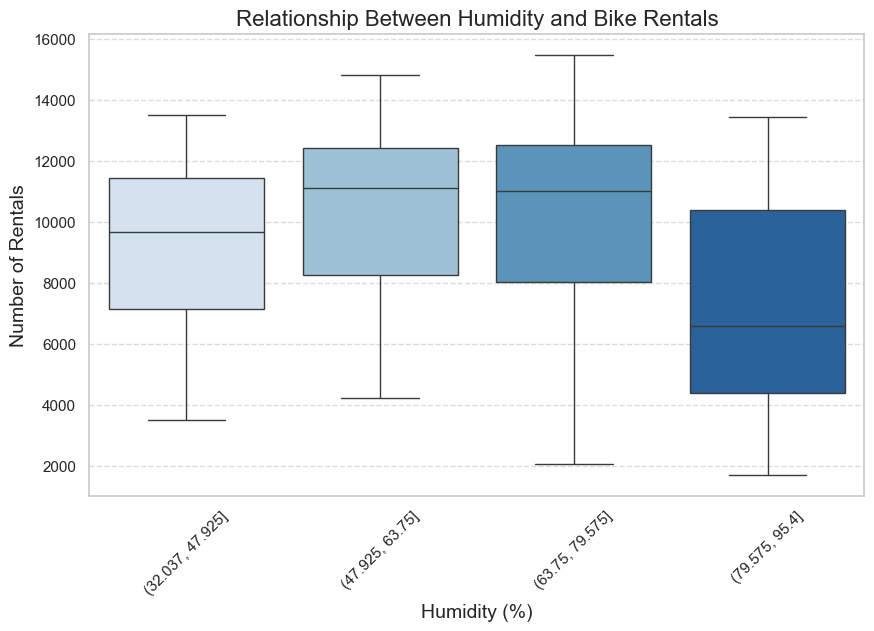

In [164]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=pd.cut(daily_data_enriched['humidity'], bins=4), y='cnt', data=daily_data_enriched, palette='Blues')
plt.title('Relationship Between Humidity and Bike Rentals', fontsize=16)
plt.xlabel('Humidity (%)', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

<h2 style="color: orange; text-align: center;">Boxplot for Relationship Between Precipitation Conditions vs Bike Rentals</h2>

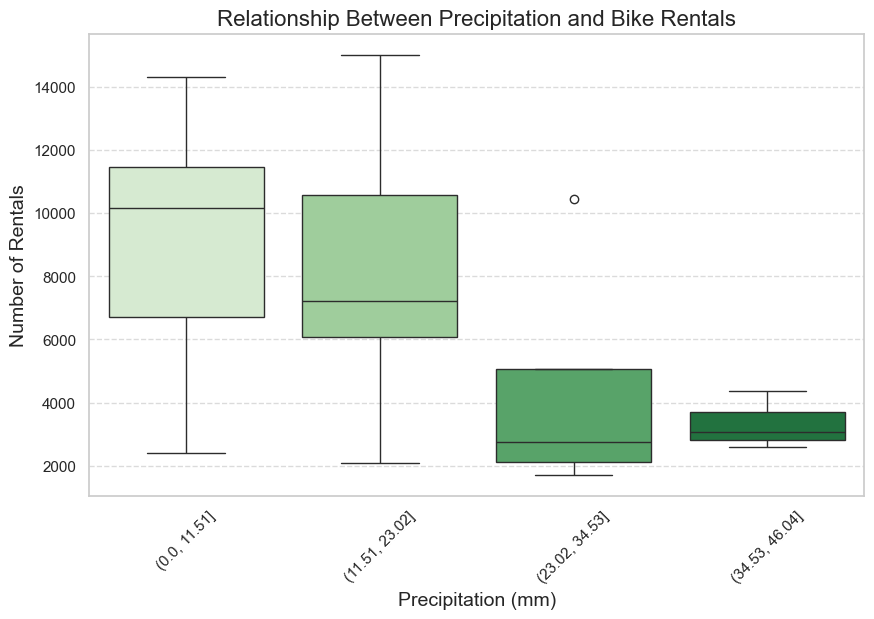

In [173]:
min_precip = daily_data_enriched['precip'].min()
max_precip = daily_data_enriched['precip'].max()

custom_bins = [min_precip, max_precip/4, max_precip/2, 3*max_precip/4, max_precip]



daily_data_enriched['precip_bins'] = pd.cut(daily_data_enriched['precip'], bins=custom_bins)

plt.figure(figsize=(10, 6))
sns.boxplot(x='precip_bins', y='cnt', data=daily_data_enriched, palette='Greens')
plt.title('Relationship Between Precipitation and Bike Rentals', fontsize=16)
plt.xlabel('Precipitation (mm)', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()


<h2 style="color: orange; text-align: center;">Boxplot for Relationship Between wind speed Conditions vs Bike Rentals</h2>

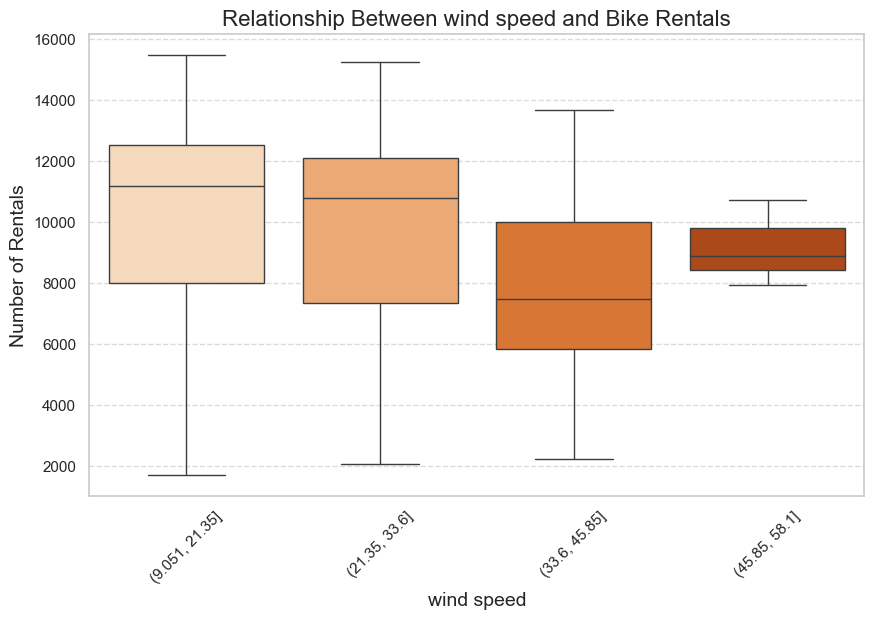

In [90]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=pd.cut(daily_data_enriched['windspeed'], bins=4), y='cnt', data=daily_data_enriched, palette='Oranges')
plt.title('Relationship Between wind speed and Bike Rentals', fontsize=16)
plt.xlabel('wind speed', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

<h2 style="color: orange; text-align: center;">Boxplot for Relationship Between UV Index Conditions vs Bike Rentals</h2>

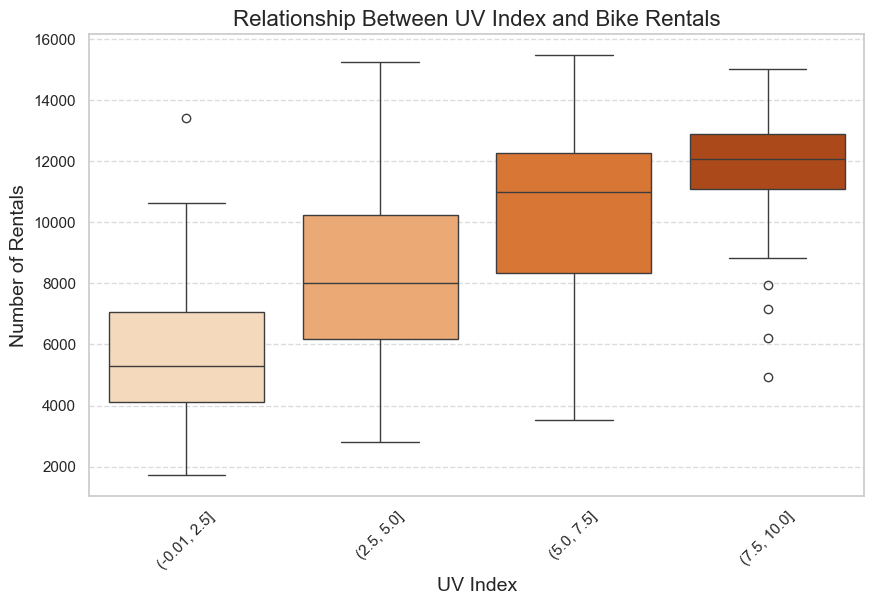

In [91]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=pd.cut(daily_data_enriched['uvindex'], bins=4), y='cnt', data=daily_data_enriched, palette='Oranges')
plt.title('Relationship Between UV Index and Bike Rentals', fontsize=16)
plt.xlabel('UV Index', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

<h2 style="color: orange; text-align: center;">Daily Trends in Bike Rentals, Trip Duration, and Temperature</h2>

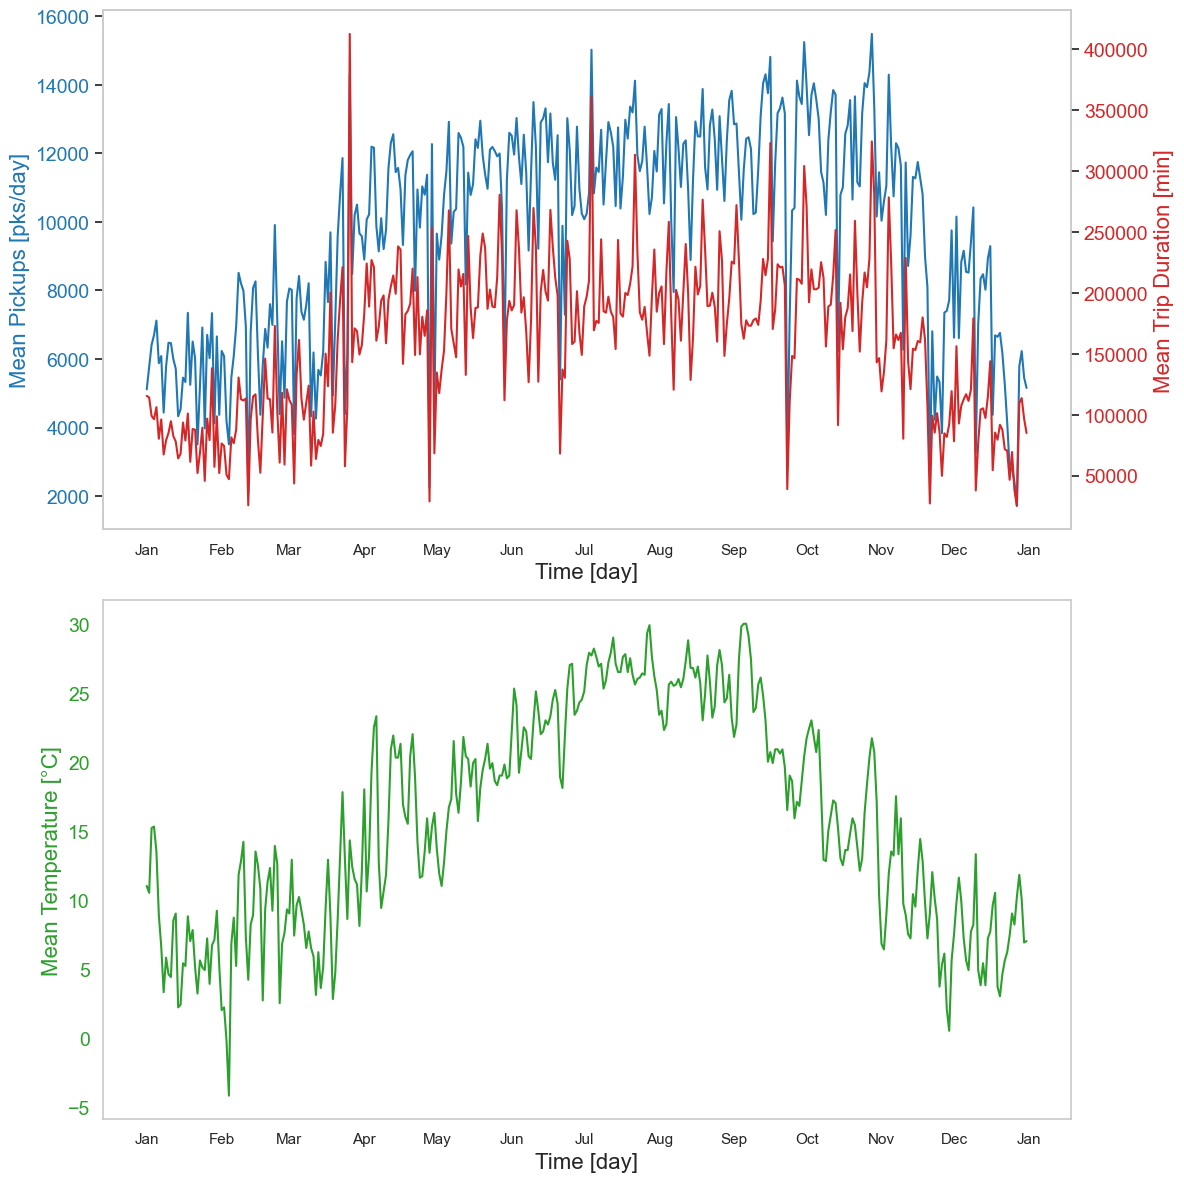

In [221]:
daily_means = daily_data_enriched.groupby('dateday').agg({
    'cnt': 'mean', 
    'duration_min': 'mean',  
    'temp': 'mean'  
}).reset_index()

daily_means['dateday'] = pd.to_datetime(daily_means['dateday'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(daily_means['dateday'], daily_means['cnt'], color='tab:blue')
ax1.set_xlabel('Time [day]', fontsize=16)
ax1.set_ylabel('Mean Pickups [pks/day]', color='tab:blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)

ax1b = ax1.twinx()
ax1b.plot(daily_means['dateday'], daily_means['duration_min'], color='tab:red')
ax1b.set_ylabel('Mean Trip Duration [min]', color='tab:red', fontsize=16)
ax1b.tick_params(axis='y', labelcolor='tab:red', labelsize=14)

ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))  
ax1.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  

ax1.grid(False)
ax1b.grid(False)

ax2.plot(daily_means['dateday'], daily_means['temp'], color='tab:green')
ax2.set_xlabel('Time [day]', fontsize=16)
ax2.set_ylabel('Mean Temperature [°C]', color='tab:green', fontsize=16)
ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=14)

ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))  
ax2.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  

ax2.grid(False)

plt.tight_layout()
plt.show()

<h2 style="color: orange; text-align: center;">Daily Trends in Bike Rentals, Trip Duration, and Precipitation</h2>

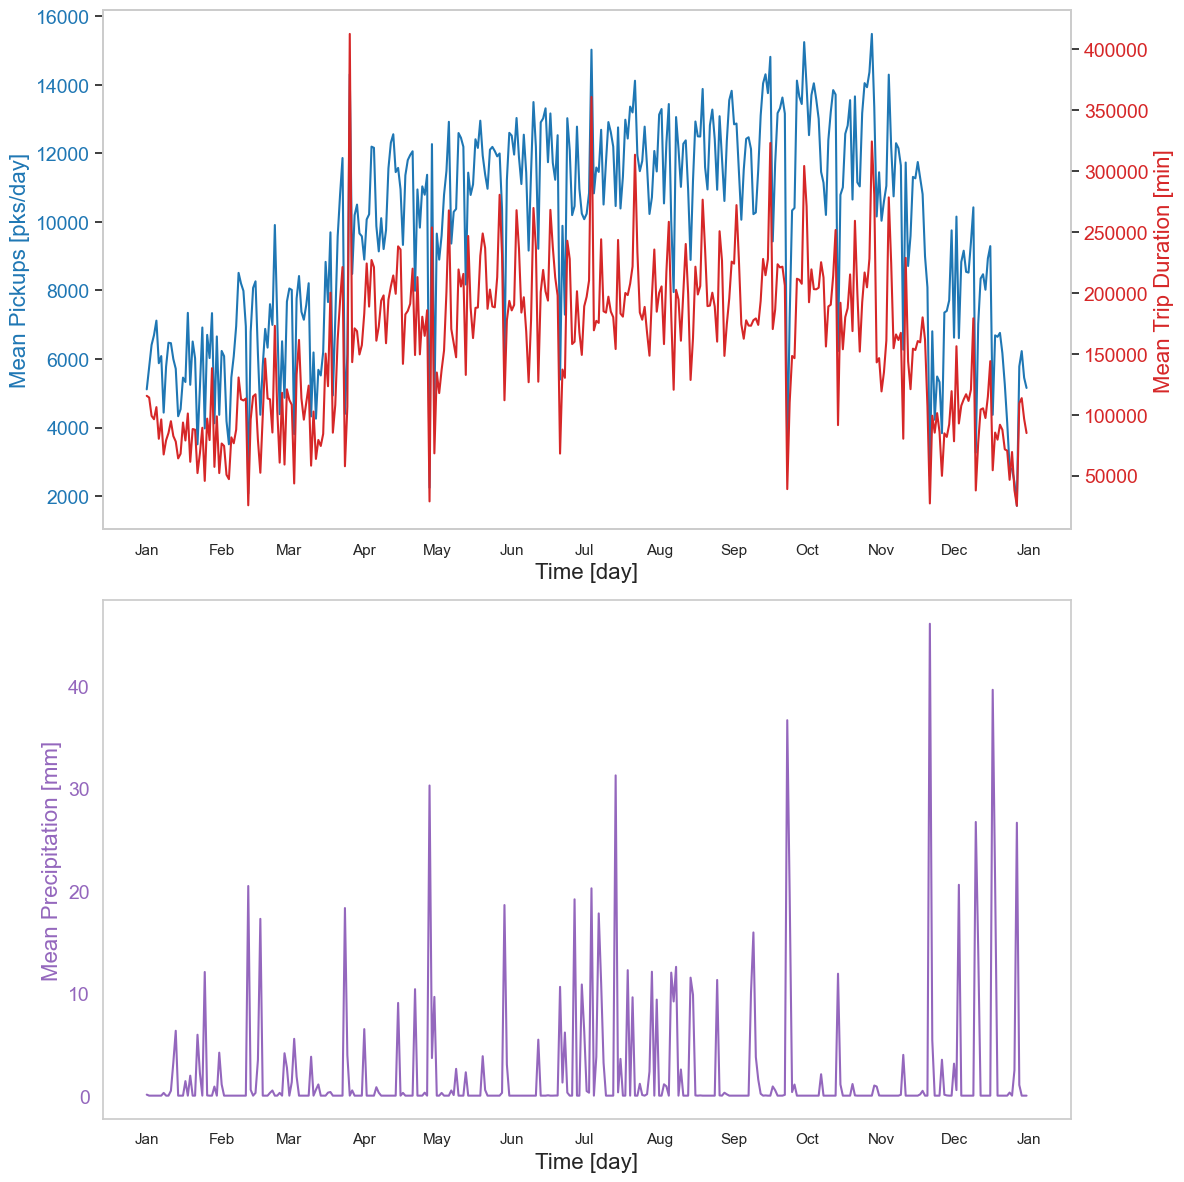

In [220]:
daily_means = daily_data_enriched.groupby('dateday').agg({
    'cnt': 'mean',  
    'duration_min': 'mean',  
    'precip': 'mean' 
}).reset_index()

daily_means['dateday'] = pd.to_datetime(daily_means['dateday'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(daily_means['dateday'], daily_means['cnt'], color='tab:blue')
ax1.set_xlabel('Time [day]', fontsize=16)
ax1.set_ylabel('Mean Pickups [pks/day]', color='tab:blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)

ax1b = ax1.twinx()
ax1b.plot(daily_means['dateday'], daily_means['duration_min'], color='tab:red')
ax1b.set_ylabel('Mean Trip Duration [min]', color='tab:red', fontsize=16)
ax1b.tick_params(axis='y', labelcolor='tab:red', labelsize=14)

ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))  
ax1.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  

ax1.grid(False)
ax1b.grid(False)

ax2.plot(daily_means['dateday'], daily_means['precip'], color='tab:purple')
ax2.set_xlabel('Time [day]', fontsize=16)
ax2.set_ylabel('Mean Precipitation [mm]', color='tab:purple', fontsize=16)
ax2.tick_params(axis='y', labelcolor='tab:purple', labelsize=14)

ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))  
ax2.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  

ax2.grid(False)

plt.tight_layout()
plt.show()

<h2 style="color: orange; text-align: center;">Descriptive Statistics of Bike-Sharing Variables</h2>

In [207]:
pickups = bike_data.groupby(['start_station_id', 'dateday']).size().reset_index(name='pickups')


bike_data['duration_min'] = (bike_data['ended_at'] - bike_data['started_at']).dt.total_seconds() / 60


trip_duration = bike_data.groupby('start_station_id')['duration_min'].agg(['min', 'max', 'mean', 'median', 'std', skew, kurtosis]).reset_index()


pickups_stats = pickups.groupby('start_station_id')['pickups'].agg(['min', 'max', 'mean', 'median', 'std', skew, kurtosis]).reset_index()


stats_table = pd.DataFrame({
    'Variable': ['Mean pickups', 'Mean trip duration'],
    'Unit': ['-', 'min'],
    'Min': [pickups_stats['min'].mean(), trip_duration['min'].mean()],
    'Max': [pickups_stats['max'].mean(), trip_duration['max'].mean()],
    'Mean': [pickups_stats['mean'].mean(), trip_duration['mean'].mean()],
    'Median': [pickups_stats['median'].mean(), trip_duration['median'].mean()],
    'Std': [pickups_stats['std'].mean(), trip_duration['std'].mean()],
    'Skew': [pickups_stats['skew'].mean(), trip_duration['skew'].mean()],
    'Kurt': [pickups_stats['kurtosis'].mean(), trip_duration['kurtosis'].mean()]
})


stats_table = stats_table.round(2)

stats_table

Variable Unit   Min     Max   Mean  Median    Std   Skew    Kurt
0        Mean pickups    -  1.67   34.23  13.24   12.99   5.85   1.08    2.21
1  Mean trip duration  min  0.48  837.54  18.10   11.42  33.82  14.73  411.14

<h2 style="color: orange; text-align: center;">Bike-Sharing Metrics: Statistical Insights</h2>

In [208]:
variables = ['cnt', 'duration_min']  
labels = ['bike rentals', 'trip duration']  
units = ['-', 'min']  

results = []


for var, label, unit in zip(variables, labels, units):
    data = daily_data_enriched[var]
    stats = {
        'Variable': label, 
        'Unit': unit,
        'Min': data.min(),
        'Max': data.max(),
        'Mean': data.mean(),
        'Median': data.median(),
        'Std': data.std(),
        'Skew.': skew(data),
        'Kurt.': kurtosis(data)
    }
    results.append(stats)


descriptive_table = pd.DataFrame(results)


descriptive_table.columns = [
    'Variable', 'Unit', 'Min', 'Max', 'Mean', 'Median', 'Std', 'Skew.', 'Kurt.'
]

descriptive_table = descriptive_table.round(2)
descriptive_table

Variable Unit       Min        Max       Mean     Median       Std  \
0   bike rentals    -   1717.00   15480.00    9752.61   10502.00   3086.25   
1  trip duration  min  25171.23  412706.37  158928.39  165917.63  63701.77   

   Skew.  Kurt.  
0  -0.53  -0.72  
1   0.17   0.03

<h2 style="color: orange; text-align: center;">Descriptive Table for Meteorological Variables</h2>

In [200]:
weather_vars = ['temp', 'feelslike', 'humidity', 'precip', 'windspeed', 'cloudcover', 'visibility', 'uvindex']

weather_stats = pd.DataFrame({
    'Variable': [var.capitalize() for var in weather_vars],
    'Unit': ['°C', '°C', '%', 'mm', 'km/h', '%', 'km', '-'],
    'Min': [daily_data_enriched[var].min() for var in weather_vars],
    'Max': [daily_data_enriched[var].max() for var in weather_vars],
    'Mean': [daily_data_enriched[var].mean() for var in weather_vars],
    'Median': [daily_data_enriched[var].median() for var in weather_vars],
    'Std': [daily_data_enriched[var].std() for var in weather_vars],
    'Skew.': [skew(daily_data_enriched[var]) for var in weather_vars],
    'Kurt.': [kurtosis(daily_data_enriched[var]) for var in weather_vars]
})


weather_stats['R2'] = [
    daily_data_enriched[[var, 'cnt']].corr().iloc[0, 1]**2 for var in weather_vars
]


weather_stats = weather_stats.round(2)

weather_stats

Variable  Unit   Min     Max   Mean  Median    Std  Skew.  Kurt.    R2
0        Temp    °C  -4.2   30.00  15.87    15.9   7.88  -0.04  -1.17  0.51
1   Feelslike    °C  -9.4   33.70  15.34    15.8   9.06  -0.14  -0.95  0.50
2    Humidity     %  32.1   95.40  63.58    63.0  13.22   0.07  -0.54  0.02
3      Precip    mm   0.0   46.04   2.26     0.0   6.08   3.86  17.24  0.10
4   Windspeed  km/h   9.1   58.10  23.66    21.9   8.08   1.04   1.31  0.04
5  Cloudcover     %   1.0  100.00  64.33    68.3  23.95  -0.59  -0.51  0.10
6  Visibility    km   4.8   16.00  15.21    15.9   1.73  -3.29  12.10  0.06
7     Uvindex     -   0.0   10.00   5.95     6.0   2.53  -0.48  -0.84  0.46

<h2 style="color: orange; text-align: center;">Visualize Bike Stations</h2>

In [179]:
bike_data['season'] = bike_data['dateday'].apply(lambda x: 'Winter' if x.month in [12, 1, 2] else
                                                      'Spring' if x.month in [3, 4, 5] else
                                                      'Summer' if x.month in [6, 7, 8] else
                                                      'Autumn')


seasonal_data = bike_data.groupby(['season', 'start_station_name', 'start_lat', 'start_lng']).size().reset_index(name='cnt')

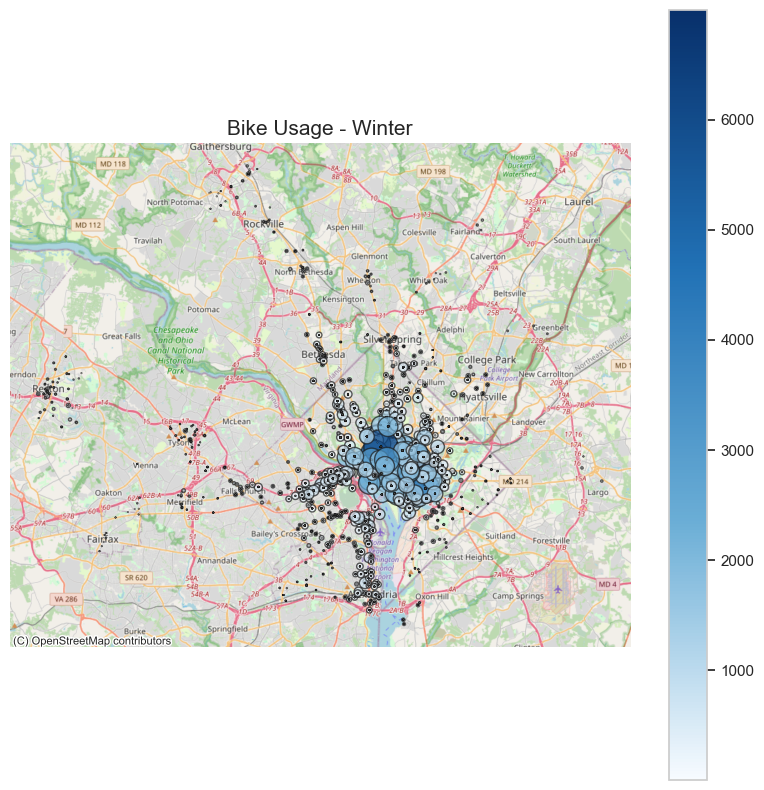

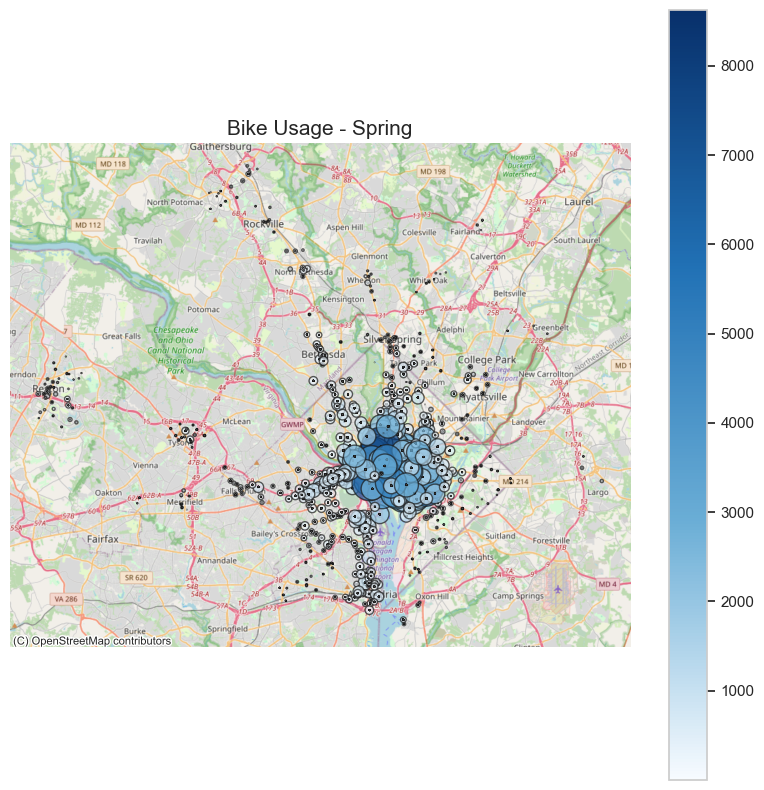

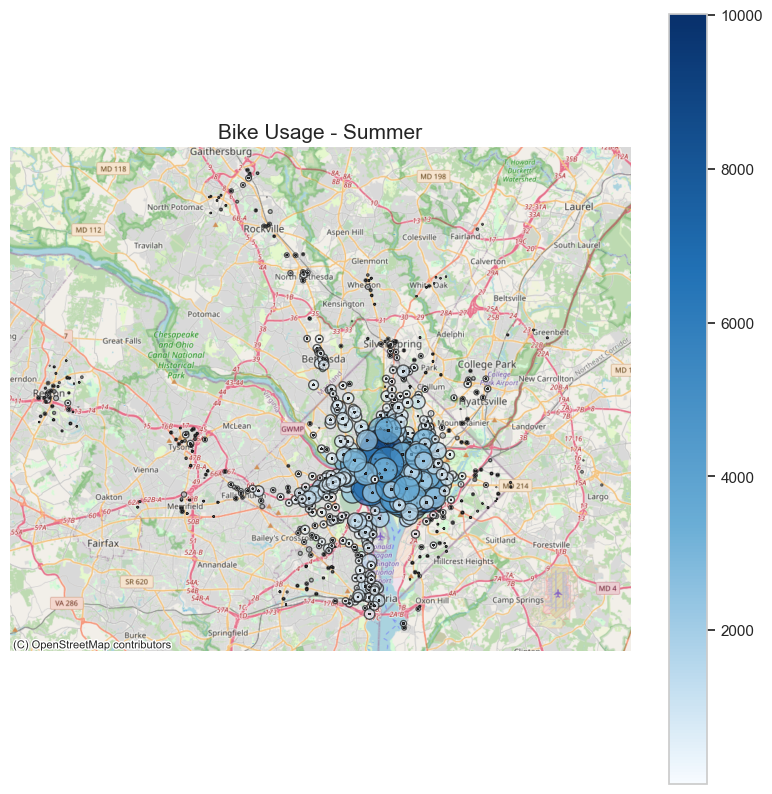

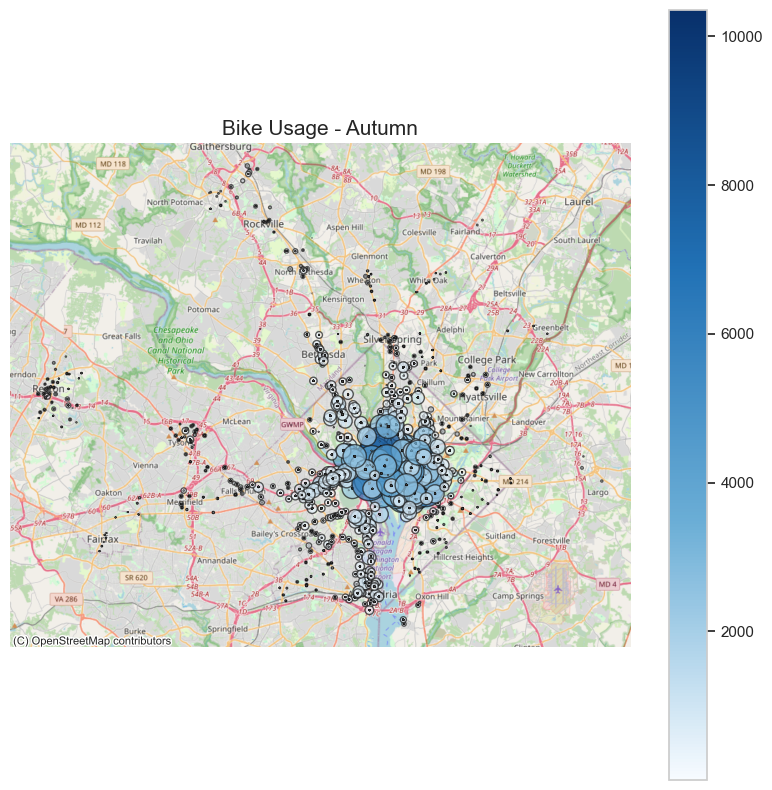

In [180]:
gdf = gpd.GeoDataFrame(
    seasonal_data,
    geometry=gpd.points_from_xy(seasonal_data['start_lng'], seasonal_data['start_lat']),
    crs="EPSG:4326"  
)


gdf = gdf.to_crs(epsg=3857)


def create_seasonal_map(season, gdf):
    
    season_data = gdf[gdf['season'] == season]
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    colors = ["#f7fbff", "#6baed6", "#2171b5", "#08306b"]  
    custom_cmap = LinearSegmentedColormap.from_list("custom_blues", colors)
    season_data.plot(ax=ax, column='cnt', cmap=custom_cmap, legend=True,
                    markersize=season_data['cnt'] / 10,  
                    alpha=0.7, edgecolor='k')
    
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    
    ax.set_title(f"Bike Usage - {season}", fontsize=15)
    ax.set_axis_off()
    
   
    file_path = os.path.join("output", f"{season.lower()}_bike_usage.png")
    plt.savefig(file_path, dpi=300, bbox_inches='tight')

    plt.savefig(f"{season.lower()}_bike_usage.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    create_seasonal_map(season, gdf)

<h2 style="color: orange; text-align: center;">Dot Density Map: Washington DC</h2>

In [ ]:
def create_dot_density_map(season, gdf):
    season_data = gdf[gdf['season'] == season]
    
 
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    for idx, row in season_data.iterrows():
       
        num_dots = int(row['cnt'] / 10)  
        ax.scatter([row.geometry.x] * num_dots, [row.geometry.y] * num_dots,
                   color='blue', s=1, alpha=0.5)  
    
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    
    ax.set_title(f"Bike Usage Dot Density Map - {season}", fontsize=15)
    ax.set_axis_off()
    
    
    plt.savefig(f"{season.lower()}_dot_density.png", dpi=300, bbox_inches='tight')
    plt.close()


for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    create_dot_density_map(season, gdf)


<h2 style="color: orange; text-align: center;">Washington DC Isoline Map</h2>

In [76]:
def create_isoline_map(season, gdf):
    season_data = gdf[gdf['season'] == season]
    
    x = season_data.geometry.x
    y = season_data.geometry.y
    
   
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    scatter = ax.scatter(x, y, c=z, cmap='viridis', s=10, alpha=0.5)
    
   
    xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    zz = np.reshape(gaussian_kde(xy)(positions), xx.shape)
    contour = ax.contour(xx, yy, zz, levels=10, colors='k', linewidths=0.5)
    
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    
    ax.set_title(f"Ride Density - {season}", fontsize=15)
    ax.set_axis_off()
    
    
    plt.colorbar(scatter, label='Ride Density')
    
    
    plt.savefig(f"{season.lower()}_isoline.png", dpi=300, bbox_inches='tight')
    plt.close()


for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    create_isoline_map(season, gdf)
